# GAN (Generative Adversarial Network)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
#  to read image from url
from imageio import imread
# to display image
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import torchvision
import torchvision.transforms as T # provides all the transformations of images
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv('../data/mnist_test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 783
dtypes: float64(784), int64(1)
memory usage: 59.9 MB


In [51]:
data = df.iloc[:, 1:].values

In [52]:
# normalize data to a range of [-1, 1]
data = data / np.max(data)
dataNorm = 2*data - 1

In [53]:
np.max(dataNorm), np.min(dataNorm)

(np.float64(1.0), np.float64(-1.0))

In [54]:
dataT = torch.tensor(dataNorm, dtype=torch.float32)
batch_size = 100

In [28]:
class discriminatorNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)

In [29]:
dnet = discriminatorNetwork()
y = dnet(torch.randn(10,784))
y

tensor([[0.4538],
        [0.4868],
        [0.4730],
        [0.4986],
        [0.4827],
        [0.4893],
        [0.4685],
        [0.4934],
        [0.4700],
        [0.4948]], grad_fn=<SigmoidBackward0>)

In [30]:
class generatorNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.out(x))
        return x

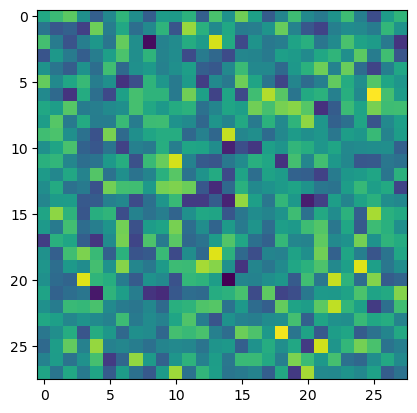

In [31]:
gnet = generatorNetwork()
y = gnet(torch.randn(10,64))
plt.imshow(y[2,:].detach().squeeze().view(28,28))

# Train the models

In [32]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [55]:
# loss function same for both phases of training
lossFun = nn.BCELoss()

dnet = discriminatorNetwork().to(device)
gnet = generatorNetwork().to(device)

# same optimizer algo but with different var parameters
# usually GAN's have small learning rates

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0003)

In [56]:
dataT.shape[0]
randidx = torch.randint(dataT.shape[0],(batch_size,))
randidx

tensor([8451, 8753, 6244,  169, 9597, 9633, 9378, 6325, 8394, 6604, 6214, 8899,
        4191, 1482, 3401, 5183, 3797, 9648, 8412, 5032, 9898, 1594, 1402, 7047,
        5737, 1025,  300, 4954,  468, 9127, 9939, 4969,  289, 4079, 2788, 2479,
        8679,  765, 4435, 7855, 2139, 1577, 2141, 3092, 7512, 3418, 8060,  154,
        6339, 4114, 6449, 5523, 9263, 7720, 4280, 3184, 1706, 7183, 1092, 4879,
         537, 3257, 7817, 9966, 3034, 2700, 3588, 1045, 1690, 1576, 7914, 5559,
        4679, 5344, 8569, 3784, 1886, 3495, 3379, 7975,  367, 7261, 6422, 7962,
        4092, 3786, 6994, 7916, 4898, 7038, 9782, 3737, 7154, 2552, 3227, 3644,
        9710, 8522, 1270, 3972])

In [57]:
real = torch.randn(batch_size, 64)
real.shape

torch.Size([100, 64])

In [58]:
def trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, num_epochs,batch_size, dataT):
    losses = np.zeros((num_epochs, 2))
    descDecision = np.zeros((num_epochs, 2))

    for epoch in range(num_epochs):

        # create mini-batches of fake and real data
        randidx = torch.randint(dataT.shape[0],(batch_size,))
        real_data = dataT[randidx,:].to(device)
        fake_data = gnet(torch.randn(batch_size, 64).to(device))

        # labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ------- TRAIN DISCRIMINATOR ------- #

        # train descriminator done on two stages 

        # 1. Train on real data

        # forward pass and loss for real pictures
        pred_real = dnet(real_data)
        d_loss_real = lossFun(pred_real, real_labels)

        # 2. Train on fake data

        # forward pass and loss for fake pictures
        pred_fake = dnet(fake_data)
        d_loss_fake = lossFun(pred_fake, fake_labels)

        # combined loss for both
        d_loss = d_loss_real + d_loss_fake
        losses[epoch, 0] = d_loss.item()
        descDecision[epoch, 0] = torch.mean((pred_real > .5).float()).detach()
        
        # backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        # ------- TRAIN GENERATOR ------- #
        
        # create fake data and compute loss 
        fake_data = gnet(torch.randn(batch_size, 64).to(device))
        pred_fake = dnet(fake_data) # here we fool(laying) the descriminator, because we want the generator model to minimize the losse 
        g_loss = lossFun(pred_fake, real_labels)
        losses[epoch, 1] = g_loss.item()
        descDecision[epoch, 1] = torch.mean((pred_fake > .5).float()).detach()

        # backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        print(f"Epoch: {epoch} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")

    return losses, descDecision


In [ ]:
labels = torch.ones(batch_size, 1).to(device)

In [59]:
losses, descDecision = trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, 40000, 500, dataT)

Epoch: 0 | Discriminator Loss: 1.4118428230285645 | Generator Loss: 0.7153392434120178
Epoch: 1 | Discriminator Loss: 1.2726597785949707 | Generator Loss: 0.7091511487960815
Epoch: 2 | Discriminator Loss: 1.1611299514770508 | Generator Loss: 0.7029135227203369
Epoch: 3 | Discriminator Loss: 1.0622754096984863 | Generator Loss: 0.6954378485679626
Epoch: 4 | Discriminator Loss: 0.9781911373138428 | Generator Loss: 0.6869088411331177
Epoch: 5 | Discriminator Loss: 0.9114394187927246 | Generator Loss: 0.677200973033905
Epoch: 6 | Discriminator Loss: 0.8628253936767578 | Generator Loss: 0.6636472344398499
Epoch: 7 | Discriminator Loss: 0.8360171914100647 | Generator Loss: 0.6484225988388062
Epoch: 8 | Discriminator Loss: 0.8243863582611084 | Generator Loss: 0.6301430463790894
Epoch: 9 | Discriminator Loss: 0.8301374316215515 | Generator Loss: 0.6099494099617004
Epoch: 10 | Discriminator Loss: 0.8479275703430176 | Generator Loss: 0.5910334587097168
Epoch: 11 | Discriminator Loss: 0.870983660

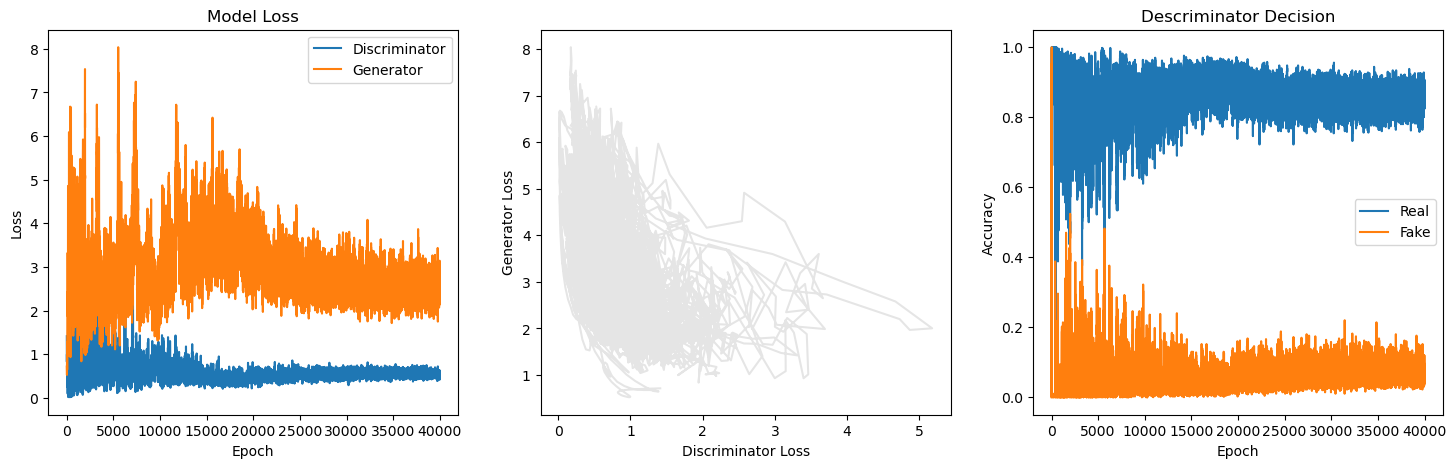

In [60]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k',alpha=.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(descDecision)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Descriminator Decision')
ax[2].legend(['Real', 'Fake'])

plt.show()


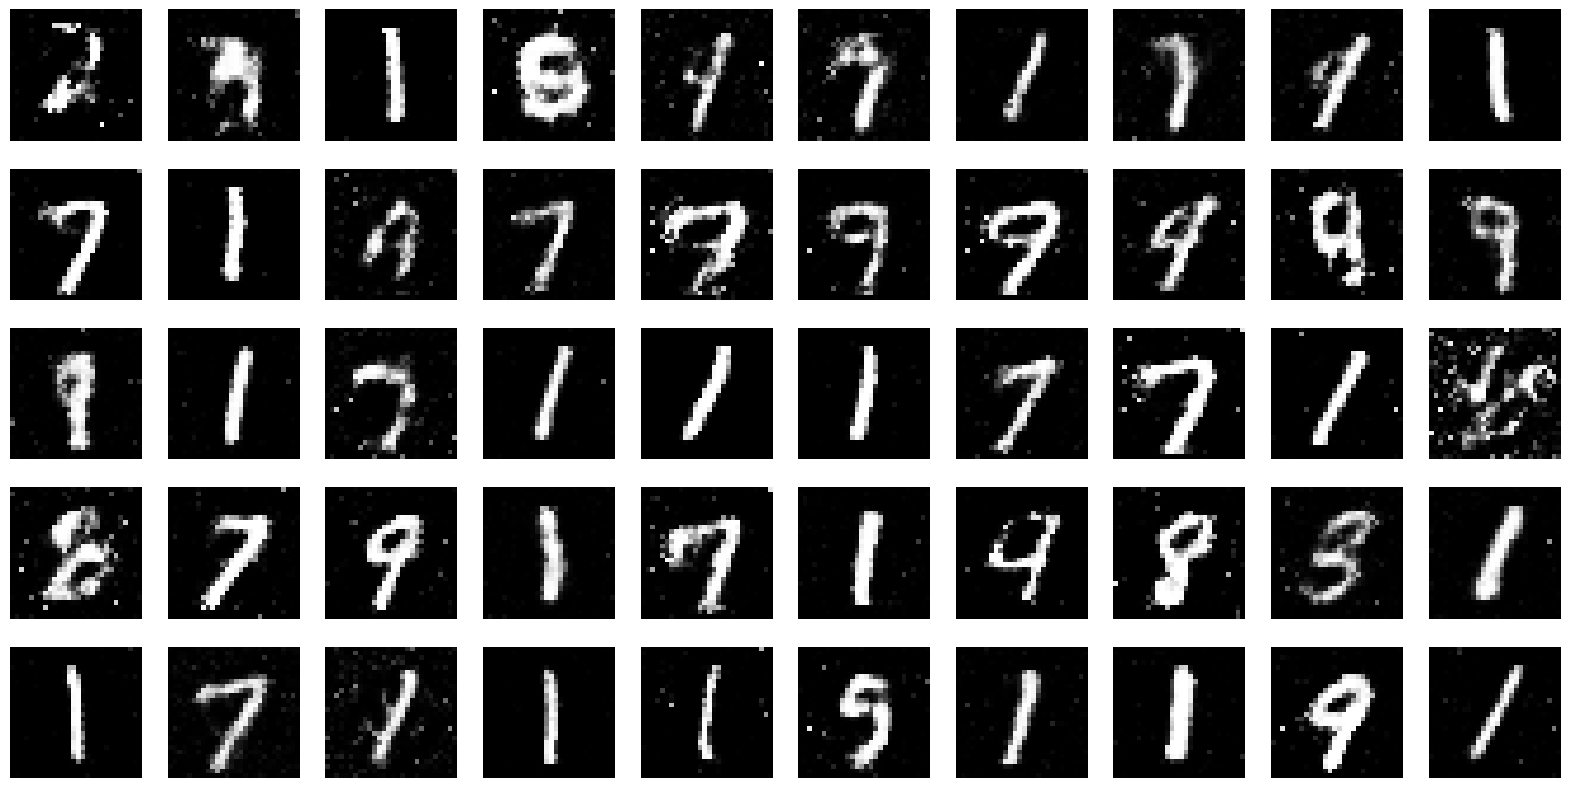

In [67]:
gnet.eval()
fake_data = gnet(torch.randn(100,64).to(device)).cpu()
fig,axs = plt.subplots(5, 10,figsize=(20,10))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

In [68]:
losses, descDecision = trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, 40000, 600, dataT)

Epoch: 0 | Discriminator Loss: 0.5689839124679565 | Generator Loss: 2.352607250213623
Epoch: 1 | Discriminator Loss: 0.5308687090873718 | Generator Loss: 2.4474987983703613
Epoch: 2 | Discriminator Loss: 0.591220498085022 | Generator Loss: 2.4772608280181885
Epoch: 3 | Discriminator Loss: 0.5351019501686096 | Generator Loss: 2.49025559425354
Epoch: 4 | Discriminator Loss: 0.5449298024177551 | Generator Loss: 2.305109977722168
Epoch: 5 | Discriminator Loss: 0.5669671893119812 | Generator Loss: 2.315563917160034
Epoch: 6 | Discriminator Loss: 0.5210813283920288 | Generator Loss: 2.3927786350250244
Epoch: 7 | Discriminator Loss: 0.5505001544952393 | Generator Loss: 2.347325325012207
Epoch: 8 | Discriminator Loss: 0.4774574637413025 | Generator Loss: 2.5310144424438477
Epoch: 9 | Discriminator Loss: 0.5543251037597656 | Generator Loss: 2.563340902328491
Epoch: 10 | Discriminator Loss: 0.5008800029754639 | Generator Loss: 2.423981189727783
Epoch: 11 | Discriminator Loss: 0.501512348651886 |

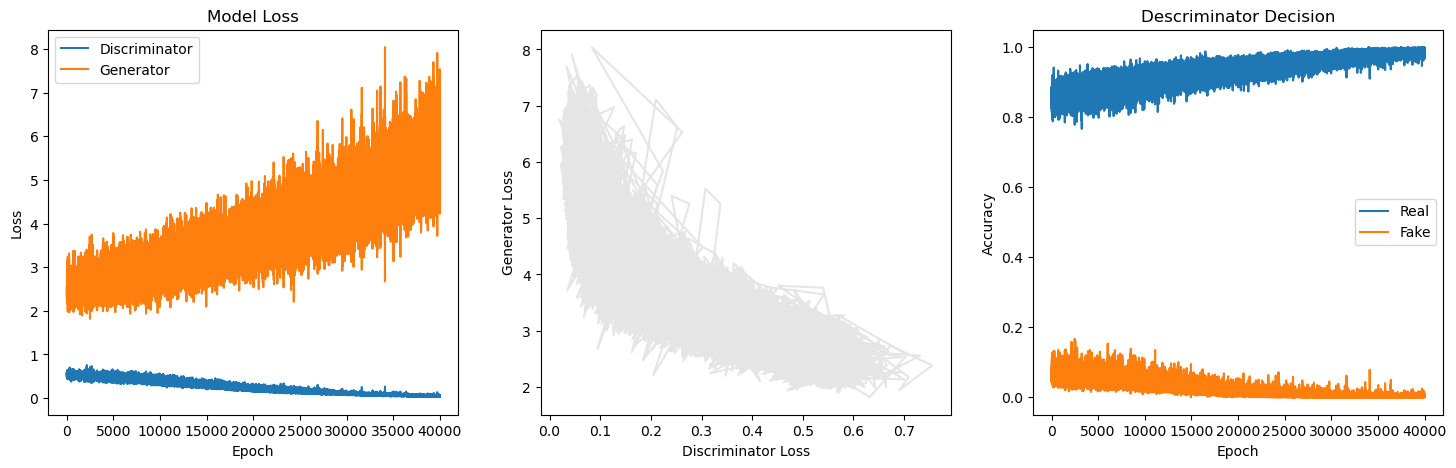

In [69]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k',alpha=.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(descDecision)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Descriminator Decision')
ax[2].legend(['Real', 'Fake'])

plt.show()


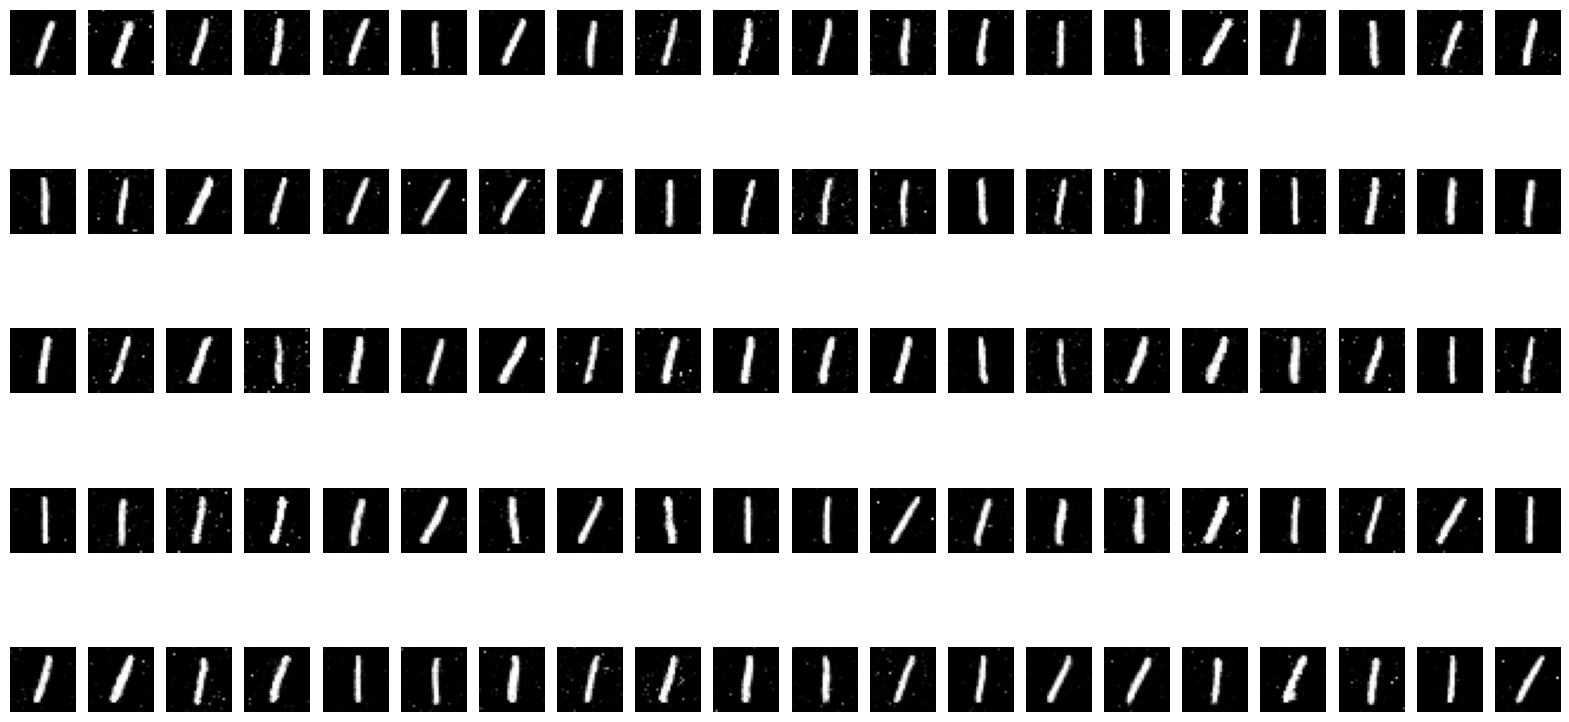

In [71]:
gnet.eval()
fake_data = gnet(torch.randn(200,64).to(device)).cpu()
fig,axs = plt.subplots(5, 20,figsize=(20,10))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()